# Project Description

## Import Libraries

In [1]:
import scjpnlib.utils as scjpnutils
from scjpnlib.utils import sql_manager as sqlmgr
import pandas as pd
import numpy as np
from IPython.core.display import HTML, Markdown
from scjpnlib.utils.file_io import FileManager
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from scjpnlib.utils.skl_transformers import DropColumnsTransformer, LambdaTransformer, SimpleValueTransformer, OneHotEncodingTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

%load_ext autoreload
%autoreload 2

pysqldfmgr = sqlmgr.PySQLDFManager(globals())

## Obtain the Data

In [2]:
fm = FileManager()

ds_map = {
    'Taarifa-Test.csv': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv', 
    'Taarifa-Train-Labels.csv': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv',
    'Taarifa-Train.csv': 'https://s3.amazonaws.com/drivendata-prod/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
}

fm.validate_download(ds_map)

## Explore the Data

In [3]:
SEED = 42 # for random_state reproducability

In [4]:
labels = pd.read_csv('Taarifa-Train-Labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [5]:
classes = labels.status_group.unique()

In [6]:
X_unlabeled = pd.read_csv('Taarifa-Test.csv')
X_labeled = pd.read_csv('Taarifa-Train.csv')
X_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [7]:
scjpnutils.analyze_values(X_labeled, 'X_labeled');

In [8]:
unexamined_candidate_removal_predictors = list(X_labeled.columns)

<p><br><br>

<h2>Clean LABELED Predictors</h2>

<p><br>
<h3>Drop Features that do NOT contribute to Classification</h3>

<p><br>
<h4>KNOWN NON-CONTRIBUTION</h4>

In [9]:
# using descriptions provided by https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list when available
# id: pure identification
# date_recorded: "The date the row was entered", so will not contribute to classification
# funder: "Who funded the well", the meaningful information seems to be held in payment
# wpt_name: "Name of the waterpoint if there is one" - again, identification purposes and will not contribute to classification
# recorded_by: "Group entering this row of data" and is constant for every observation - will not contribute to classification
non_contrib_feats = feats_to_reintegrate_later = [
    'id', 
    'date_recorded', 
    'funder',
    'wpt_name', 
    'recorded_by'
]
X_labeled_reintegrate_later = X_labeled[feats_to_reintegrate_later]

dct_non_contrib_predictors = DropColumnsTransformer(non_contrib_feats)
# basis for cleaned labeled predictors
X_labeled_clean = dct_non_contrib_predictors.fit_transform(X_labeled)

# do the same for "throw-away" version of X_unlabeled since we will use union of unique categories between it and X_labeled_clean for one-hot encoding
X_unlabeled_throw_away = dct_non_contrib_predictors.fit_transform(X_unlabeled)

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in non_contrib_feats, unexamined_candidate_removal_predictors))

<p><br>
<h3>Fix/replace NULL/MISSING values</h3>

<h4>funder:</h4>

In [10]:
# check to see if there is an appropriate value in X_labeled.funder to indicate null - e.g. 'None' or 'none'
scjpnutils.index_of_values(X_labeled, 'X_labeled', 'funder', ['None', 'none'])

(array([ 4868, 19055]), array(['None'], dtype=object))

In [11]:
# so let's replace all null funder values with 'None'
replace_null_rules = {'funder': [{'missing_values': np.nan, 'strategy': 'constant', 'fill_value': 'None'}]}

<p><br>
<h4>installer:</h4>

In [12]:
# check to see if there is an appropriate value in X_labeled.installer to indicate null - e.g. 'None' or 'none'
scjpnutils.index_of_values(X_labeled, 'X_labeled', 'installer', ['None', 'none'])

(array([], dtype=int64), array([], dtype=object))

In [13]:
# there doesn't appear to be, so let's create this semantic and replace all null installer values with 'None'
replace_null_rules['installer'] = [
    {
        'missing_values': np.nan,
        'strategy': 'constant', 
        'fill_value': 'None'
    }
]

<p><br>
<h4>subvillage:</h4>

In [14]:
# check to see if there is an appropriate value in X_labeled.subvillage to indicate null - e.g. 'None' or 'none'
scjpnutils.index_of_values(X_labeled, 'X_labeled', 'subvillage', ['None', 'none'])

(array([], dtype=int64), array([], dtype=object))

In [15]:
replace_null_rules['subvillage'] = [
    {
        'missing_values': np.nan,
        'strategy': 'constant', 
        'fill_value': 'None'
    }
]

<p><br>
<h4>public_meeting:</h4>

In [16]:
# we see above that list of unique values for public_meeting is [True, nan, False] so we will replace nan (null) with False - we don't know that this is correct yet... default could be True
replace_null_rules['public_meeting'] = [
    {
        'missing_values': np.nan,
        'strategy': 'constant', 
        'fill_value': False
    }
]

<p><br>
<h4>scheme_management:</h4>

In [17]:
X_labeled.scheme_management.unique()

array(['VWC', 'Other', nan, 'Private operator', 'WUG', 'Water Board',
       'WUA', 'Water authority', 'Company', 'Parastatal', 'Trust', 'SWC',
       'None'], dtype=object)

In [18]:
# we see above that list of unique values for scheme_management has 'None' so we will replace nan (null) with 'None'
replace_null_rules['scheme_management'] = [
    {
        'missing_values': np.nan,
        'strategy': 'constant', 
        'fill_value': 'None'
    }
]

<p><br>
<h4>scheme_name:</h4>

In [19]:
# check to see if there is an appropriate value in X_labeled.scheme_name to indicate null - e.g. 'None' or 'none'
scjpnutils.index_of_values(X_labeled, 'X_labeled', 'scheme_name', ['None', 'none'])

(array([   14,   101,   572,   614,   619,   705,   708,   732,   781,
          855,   887,   893,  1036,  1133,  1188,  1244,  1405,  1538,
         1645,  1672,  1760,  1850,  1869,  1871,  2180,  2181,  2203,
         2302,  2392,  2570,  2730,  2736,  2764,  2769,  2852,  3053,
         3339,  3352,  3356,  3676,  3741,  3890,  4028,  4046,  4121,
         4271,  4290,  4376,  4567,  4604,  4661,  4665,  4678,  4713,
         4757,  4758,  4773,  4827,  4898,  5002,  5172,  5200,  5254,
         5325,  5343,  5488,  5492,  5496,  5595,  5693,  5791,  5828,
         5853,  6162,  6225,  6244,  6476,  6537,  6599,  6685,  6728,
         6734,  6811,  6850,  6980,  7182,  7184,  7193,  7239,  7333,
         7655,  7679,  8190,  8263,  8320,  8377,  8590,  8755,  8816,
         8864,  8885,  8968,  9025,  9224,  9287,  9435,  9459,  9476,
         9778,  9788,  9938, 10063, 10115, 10167, 10217, 10221, 10319,
        10378, 10460, 10565, 10624, 10693, 10826, 10849, 10903, 11051,
      

In [20]:
# from the above, we see that scheme_name has BOTH 'None' and 'none', so we will replace nan and 'none' with 'None'
replace_null_rules['scheme_name'] = [
    {
        'missing_values': np.nan,
        'strategy': 'constant', 
        'fill_value': 'None'
    },
    {
        'missing_values': 'none',
        'strategy': 'constant', 
        'fill_value': 'None'
    }
]

<p><br>
<h4>permit:</h4>

In [21]:
# we see above that list of unique values for permit is [True, nan, False] so we will replace nan (null) with False
replace_null_rules['permit'] = [
    {
        'missing_values': np.nan,
        'strategy': 'constant', 
        'fill_value': False
    }
]

<p><br>
<h4>Now execute the above null-value replacement rules</h4>

In [22]:
nvt_null_predictors = SimpleValueTransformer(replace_null_rules)
X_labeled_clean = nvt_null_predictors.fit_transform(X_labeled_clean)

# do the same for "throw-away" version of X_unlabeled since we will use union of unique categories between it and X_labeled_clean for one-hot encoding
X_unlabeled_throw_away = nvt_null_predictors.transform(X_unlabeled_throw_away)

scjpnutils.analyze_values(X_labeled_clean, 'X_labeled_clean', standard_options_kargs={'sort_unique_vals':True});

As you can see above, there are now no features with null/missing values.

<p><br>
<h3>Drop Features that DUPLICATE other Features</h3>

In [23]:
dup_features_to_drop = []

In [24]:
extraction_type_feats = [
    'extraction_type', # "The kind of extraction the waterpoint uses", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'extraction_type_group', # "The kind of extraction the waterpoint uses", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'extraction_type_class' # "The kind of extraction the waterpoint uses", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
]

scjpnutils.analyze_duplicates('Extraction', extraction_type_feats, 'X_labeled_clean', X_labeled_clean)

We will settle on keeping <b>extraction_type_class</b> since it represents class membership for each instance of <b>extraction_type</b> and <b>extraction_type_group</b> (which will be dropped).

In [25]:
dup_features_to_drop.append('extraction_type')
feats_to_reintegrate_later.append('extraction_type')

dup_features_to_drop.append('extraction_type_group')
feats_to_reintegrate_later.append('extraction_type_group')

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in extraction_type_feats, unexamined_candidate_removal_predictors))

<p><br>

In [26]:
management_feats = [
    'management', # "How the waterpoint is managed", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'management_group' # "How the waterpoint is managed", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
]

scjpnutils.analyze_duplicates('Management', management_feats, 'X_labeled_clean', X_labeled_clean)

We will settle on keeping <b>management_group</b> since it represents class membership for each instance of <b>management</b> (which will be dropped).

In [27]:
dup_features_to_drop.append('management')
feats_to_reintegrate_later.append('management')

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in management_feats, unexamined_candidate_removal_predictors))

<p><br>

In [28]:
payment_feats = [
    'payment', # "What the water costs", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'payment_type' # "What the water costs", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
]

scjpnutils.analyze_duplicates('Payment', payment_feats, 'X_labeled_clean', X_labeled_clean)

Each set is the same length in magnitude but we will settle on keeping <b>payment_type</b> since its categories contain the same information in a smaller memory footprint than <b>payment</b> (which will be dropped).

In [29]:
dup_features_to_drop.append('payment')
feats_to_reintegrate_later.append('payment')

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in payment_feats, unexamined_candidate_removal_predictors))

<p><br>

In [30]:
quality_feats = [
    'water_quality', # "The quality of the water", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'quality_group' # "The quality of the water", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
]

scjpnutils.analyze_duplicates('Quality', quality_feats, 'X_labeled_clean', X_labeled_clean)

We will settle on keeping <b>quality_group</b> since it represents class membership for each instance of <b>water_quality</b> (which will be dropped).  In addition, <b>quality_group</b> makes clear when water quality is "good" via the <b>good</b> class, while the corresponding category <b>soft</b> in <b>water_quality</b> may not be as clear to non-technical stakeholders.

In [31]:
dup_features_to_drop.append('water_quality')
feats_to_reintegrate_later.append('water_quality')

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in quality_feats, unexamined_candidate_removal_predictors))

<p><br>

In [32]:
quantity_feats = [
    'quantity', # "The quantity of water", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'quantity_group' # "The quantity of water", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
]

scjpnutils.analyze_duplicates('Quantity', quantity_feats, 'X_labeled_clean', X_labeled_clean)

It certainly does not get any clearer than that, does it?!  Each set is the same length in magnitude and has the exact same categories but, since we will be one-hot encoding later, the column name of <b>quantity</b> will have a a smaller memory footprint than <b>quantity_group</b> (which will be dropped).

In [33]:
dup_features_to_drop.append('quantity_group')
feats_to_reintegrate_later.append('quantity_group')

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in quantity_feats, unexamined_candidate_removal_predictors))

<p><br>

In [34]:
source_feats = [
    'source', # "The source of the water", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'source_type', # "The source of the water", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'source_class' # "The source of the water", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
]

scjpnutils.analyze_duplicates('Source', source_feats, 'X_labeled_clean', X_labeled_clean)

This one is a bit tricker in that there isn't much overlap between explicit category values.  From the outset, we see that <b>source_class</b> is far too general and both of the other categorical variables contain more specific/differentiating categories.  So, <b>source_class</b> will be dropped.  Between <b>source</b> and <b>source_type</b> there is a lot of overlap in categories.  But <b>source</b> contains mutually exclusive (orthogonal) categories while <b>source_type</b> contains some categories which combine would-be orthogonal categories - e.g. category <b>river/lake</b> in <b>source_type</b>.  In addition, during one-hot encoding the presence of a "/", while can be dealt with, adds extra, unecessary work when <b>source</b> does not.

In [35]:
dup_features_to_drop.append('source_class')
feats_to_reintegrate_later.append('source_class')

dup_features_to_drop.append('source_type')
feats_to_reintegrate_later.append('source_type')

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in source_feats, unexamined_candidate_removal_predictors))

<p><br>

In [36]:
waterpoint_feats = [
    'waterpoint_type', # "The kind of waterpoint", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'waterpoint_type_group' # "The kind of waterpoint", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
]

scjpnutils.analyze_duplicates('Waterpoint', waterpoint_feats, 'X_labeled_clean', X_labeled_clean)

This one is fairly straightforward.  Since the task is aimed at pump-condition (including failure) classification and it stands to reason that a <b>communal standpipe multiple</b> has more potential points of failure (relative to a single <b>communal standpipe</b>), then it would be valuable to capture this information held in <b>waterpoint_type</b>.

In [37]:
dup_features_to_drop.append('waterpoint_type_group')
feats_to_reintegrate_later.append('waterpoint_type_group')

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in waterpoint_feats, unexamined_candidate_removal_predictors))

<p><br>

In [38]:
geoloc_feats = [
    'longitude', # "GPS coordinate", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'latitude', # "GPS coordinate", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'gps_height', # "Altitude of the well", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'subvillage', # "Geographic location", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'region', # "Geographic location", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'region_code', # "Geographic location", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'district_code', # "Geographic location", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'lga', # "Geographic location", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'ward' # "Geographic location", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
]

scjpnutils.analyze_duplicates('Geographic Location', geoloc_feats, 'X_labeled_clean', X_labeled_clean)

It is easy to think that all of the above information is important since there is little to no overlap when holding data-types fixed.  However, all of this information, per the descriptions provided, refer to a location.  We already have not only very precise information contained in <b>longitude</b> and <b>latitude</b>, but even more information with the addition of <b>gps_height</b>.  Additionally, every other bit of location information can be mapped from GPS coordinates, therefore we will drop every Geographic Location feature other than <b>longitude</b>, <b>latitude</b>, and <b>gps_height</b>.

In [39]:
geoloc_feats_to_drop = geoloc_feats.copy()
geoloc_feats_to_drop.remove('longitude')
geoloc_feats_to_drop.remove('latitude')
geoloc_feats_to_drop.remove('gps_height')
dup_features_to_drop.extend(geoloc_feats_to_drop)
feats_to_reintegrate_later.extend(geoloc_feats_to_drop)

unexamined_candidate_removal_predictors = list(filter(lambda p: p not in geoloc_feats, unexamined_candidate_removal_predictors))

<p><br>
<h4>Now execute the drop</h4>

In [40]:
X_labeled_reintegrate_later = X_labeled[feats_to_reintegrate_later]

dct_dup_predictors = DropColumnsTransformer(dup_features_to_drop)
# basis for cleaned labeled predictors
X_labeled_clean = dct_dup_predictors.fit_transform(X_labeled_clean)
scjpnutils.analyze_values(X_labeled_clean, 'X_labeled_clean (after dropping duplicate information)', standard_options_kargs={'sort_unique_vals':True});

# do the same for "throw-away" version of X_unlabeled since we will use union of unique categories between it and X_labeled_clean for one-hot encoding
X_unlabeled_throw_away = dct_dup_predictors.fit_transform(X_unlabeled_throw_away)

unexamined_predictors = unexamined_candidate_removal_predictors.copy()
unexamined_candidate_removal_predictors = None

The above dataframe constitutes our base labeled set of predictors.  Before going further, we will first split our baseline into our corresponding <b>labeled</b> train and test data.

<p><br>
<h3>Test/Train Split</h3>

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled_clean, labels.status_group, test_size=0.20, random_state=SEED)

In [42]:
y_train.value_counts()

functional                 25802
non functional             18252
functional needs repair     3466
Name: status_group, dtype: int64

In [43]:
scjpnutils.analyze_values(pd.DataFrame(y_train, columns=['status_group']), 'y_train');

In [44]:
scjpnutils.analyze_values(X_train, 'X_train', standard_options_kargs={'sort_unique_vals':True});

<p><br><br>
<h3>Identify and Prepare CONTINUOUS (ordinal) Features</h3>

In [45]:
cont_feats = [
    'amount_tsh', # "Total static head (amount water available to waterpoint)", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
    'gps_height', # "Altitude of the well", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/
    'longitude', # "GPS coordinate", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/; this is ordinal since it is defined as "Angular distance on the earth's surface, measured east or west from the Prime Meridian"
    'latitude', # "GPS coordinate", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/; this is ordinal since it is defined as "The angular distance north or south of the earth's equator, measured in degrees along a meridian"
    'num_private', # no documentation provided at https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/ but we will treat it as ordinal for now since it seems to indicate a count or amount of something
    'population', # "Population around the well", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/
    'construction_year' # "Year the waterpoint was constructed", per https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/
]

ft_sel_cont = FunctionTransformer(lambda X: X[cont_feats], validate=False)
X_train_cont = ft_sel_cont.fit_transform(X_train)

scjpnutils.analyze_values(X_train_cont, 'X_train_cont', standard_options_kargs={'sort_unique_vals':True});

From the above, with the exception of <b>num_private</b>, it is clear that these features are ordinal.  Since we are not given a clear definition of <b>num_private</b> and its data type is `int64`, we will continue to treat it as a <i>Continuous</i> feature.

<p><br>
<h4>Consider Outliers</h4>

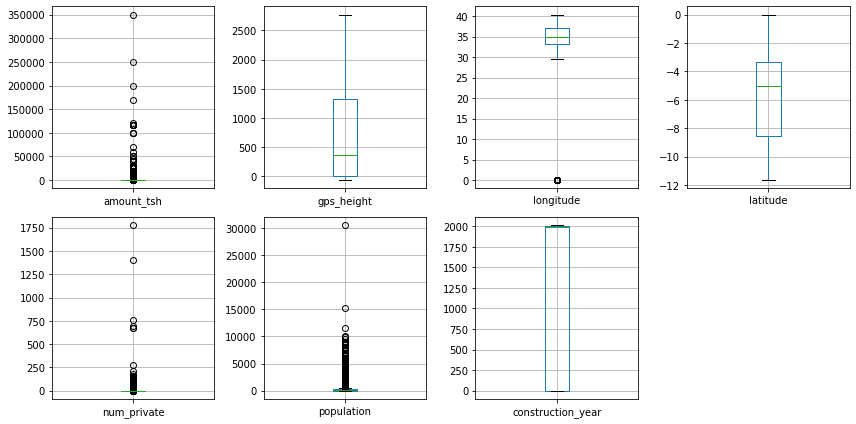

feature    dtype         q1           q3  IQR_lower_bound  \
0         amount_tsh  float64   0.000000    20.000000       -30.000000   
1         gps_height    int64   0.000000  1320.000000     -1980.000000   
2          longitude  float64  33.084320    37.180585        26.939922   
3           latitude  float64  -8.532465    -3.326464       -16.341467   
4        num_private    int64   0.000000     0.000000         0.000000   
5         population    int64   0.000000   213.000000      -319.500000   
6  construction_year    int64   0.000000  2004.000000     -3006.000000   

   IQR_upper_bound n_outliers  n_outliers_ratio  \
0        50.000000       8894          0.187163   
1      3300.000000          0          0.000000   
2        43.324983       1433          0.030156   
3         4.482537          0          0.000000   
4         0.000000        617          0.012984   
5       532.500000       3498          0.073611   
6      5010.000000          0          0.000000   

                                      outliers_index  
0  Int64Index([50091,  2211, 41673, 28608, 31375,...  
1                      Int64Index([], dtype='int64')  
2  Int64Index([22823, 18591, 15879,  8322,  9750,...  
3                      Int64Index([], dtype='int64')  
4  Int64Index([44954, 39240,  9992, 33884, 34125,...  
5  Int64Index([54042, 56498, 39889, 37730, 46261,...  
6                      Int64Index([], dtype='int64')

In [46]:
scjpnutils.analyze_outliers(X_train_cont, 'X_train_cont', display_plots=True, plot_edge=3)

From the above, we see that <b>amount_tsh</b>, <b>longitude</b>, <b>num_private</b>, and <b>population</b> evidently have outliers.

Let us now analyze each of those features in detail.

<p><br>
<h4>amount_tsh:</h4>

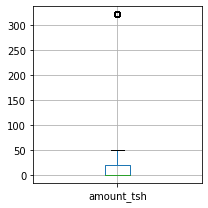

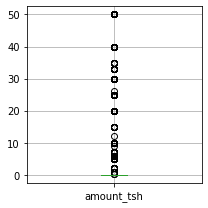

In [47]:
amount_tsh_outlier_replacement_rules = scjpnutils.analyze_outliers_detailed(
    X_train_cont, 
    'X_train_cont', 
    'amount_tsh', 
    top_percentile=90, 
    outlier_ratio_reduction_threshold=.10
)

Output of the analysis speaks for itself.  So we will follow the recommendation and drop feature <b>amount_tsh</b>.

In [48]:
cont_feats_to_drop = ['amount_tsh']
feats_to_reintegrate_later.append('amount_tsh')
unexamined_predictors.remove('amount_tsh')

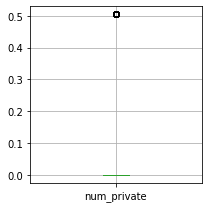

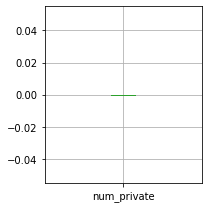

In [49]:
num_private_outlier_replacement_rules = scjpnutils.analyze_outliers_detailed(
    X_train_cont, 
    'X_train_cont', 
    'num_private', 
    top_percentile=90, 
    outlier_ratio_reduction_threshold=.10
)

Reviewing the above analysis indicates that 58 out of 59 unique values are considered outliers.  Even though analysis recommends replacement with the mean value, we will forego that recommendation and instead <u>drop the <b>num_private</b> feature</u>.

In [50]:
cont_feats_to_drop.append('num_private')
feats_to_reintegrate_later.append('num_private')
unexamined_predictors.remove('num_private')

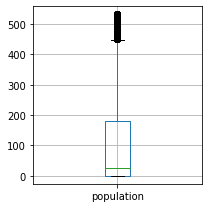

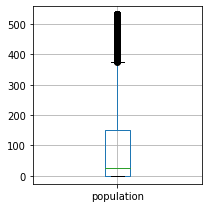

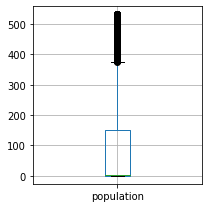

In [51]:
population_outlier_replacement_rules = scjpnutils.analyze_outliers_detailed(
    X_train_cont, 
    'X_train_cont', 
    'population', 
    top_percentile=90, 
    outlier_ratio_reduction_threshold=.10
)

Again, we will follow the recommendation.

In [52]:
cont_feat_outlier_replacement_rules = {}
cont_feat_outlier_replacement_rules.update(population_outlier_replacement_rules)
unexamined_predictors.remove('population')

<p><br>
<h4>Now execute the drop</h4>

In [53]:
X_labeled_reintegrate_later = X_labeled[feats_to_reintegrate_later]

dct_cont_predictors_with_bad_outliers = DropColumnsTransformer(cont_feats_to_drop)
X_train_cont = dct_cont_predictors_with_bad_outliers.fit_transform(X_train_cont)

scjpnutils.analyze_values(X_train_cont, 'X_train_cont (after dropping features with bad outliers)', standard_options_kargs={'sort_unique_vals':True});

<p><br>
<h4>Now replace outliers with the replacement rules output from prior outlier-analysis</h4>

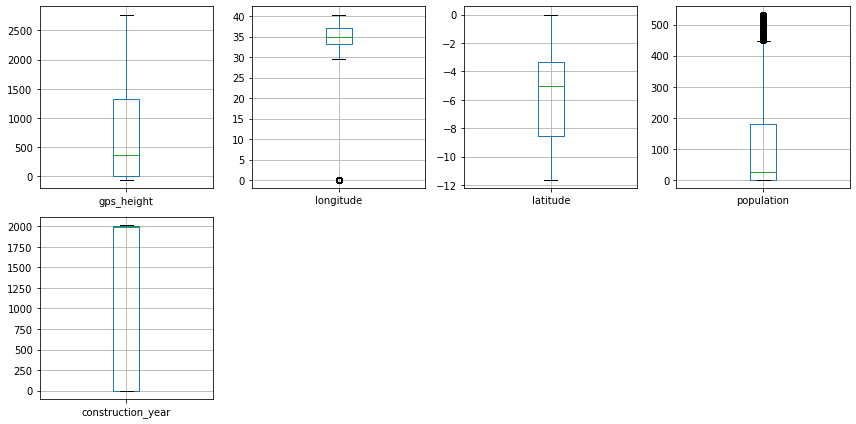

feature    dtype         q1           q3  IQR_lower_bound  \
0         gps_height    int64   0.000000  1320.000000     -1980.000000   
1          longitude  float64  33.084320    37.180585        26.939922   
2           latitude  float64  -8.532465    -3.326464       -16.341467   
3         population  float64   0.000000   179.528283      -269.292424   
4  construction_year    int64   0.000000  2004.000000     -3006.000000   

   IQR_upper_bound n_outliers  n_outliers_ratio  \
0      3300.000000          0          0.000000   
1        43.324983       1433          0.030156   
2         4.482537          0          0.000000   
3       448.820707       1682          0.035396   
4      5010.000000          0          0.000000   

                                      outliers_index  
0                      Int64Index([], dtype='int64')  
1  Int64Index([22823, 18591, 15879,  8322,  9750,...  
2                      Int64Index([], dtype='int64')  
3  Int64Index([ 2732, 33277, 40922, 42141, 13762,...  
4                      Int64Index([], dtype='int64')

In [54]:
svt_cont_outlier_predictors = SimpleValueTransformer(cont_feat_outlier_replacement_rules)
X_train_cont = svt_cont_outlier_predictors.fit_transform(X_train_cont)

scjpnutils.analyze_outliers(X_train_cont, 'X_train_cont', display_plots=True, plot_edge=3)

"Outlier" <b>longitude</b> vales really aren't outliers.  Additionally, we should not touch those since those are precise GPS coordinates.  But, for the sake of being thorough, let's do another round of outlier analysis on both <b>num_private</b> and <b>population</b>.

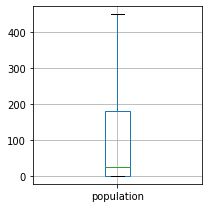

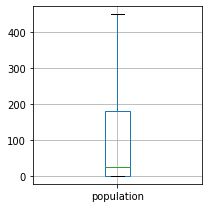

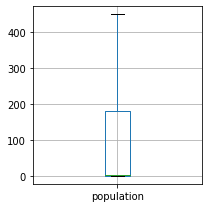

In [55]:
scjpnutils.analyze_outliers_detailed(
    X_train_cont, 
    'X_train_cont', 
    'population', 
    top_percentile=90, 
    outlier_ratio_reduction_threshold=.10
);

Even though we could theoretically reduce outlier count to 0 for <b></b> but doing a second round of mean-value replacement, I think this would skew the data too much.  Recall that after the first round of mean-value replacement, we ended up reducing outlier-ratio to 3.54%, which seems acceptable.  So we will forego going through a second round of replacement of <b>population</b> outlier-values.

This leaves us with our final form of train continuous predictors, ready for scaling.

<p><br>
<h4>Scale</h4>

In [56]:
final_cont_feats = list(X_train_cont.columns)

In [57]:
scaler = MinMaxScaler()
scaled_X_train_cont = pd.DataFrame(scaler.fit_transform(X_train_cont), columns=X_train_cont.columns, index=X_train_cont.index)
scaled_X_train_cont.describe()

gps_height     longitude      latitude    population  \
count  47520.000000  47520.000000  47520.000000  47520.000000   
mean       0.258293      0.844991      0.510277      0.191891   
std        0.244607      0.162062      0.252673      0.251915   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.022238      0.820031      0.267564      0.000000   
50%        0.152842      0.865324      0.569276      0.046992   
75%        0.488175      0.921562      0.714453      0.337459   
max        1.000000      1.000000      1.000000      1.000000   

       construction_year  
count       47520.000000  
mean            0.647468  
std             0.472312  
min             0.000000  
25%             0.000000  
50%             0.986587  
75%             0.995529  
max             1.000000

<p><br><br>
<h3>Identify and Prepare CATEGORICAL Features (for One-Hot Encoding)</h3>

In [58]:
dct_cat_predictors_from_cont_predictors = DropColumnsTransformer(cont_feats + cont_feats_to_drop)
X_train_cat = dct_cat_predictors_from_cont_predictors.fit_transform(X_train)
# do the same for "throw-away" version of X_unlabeled and X_test since we will use union of unique categories between them for one-hot encoding
X_unlabeled_cat_throw_away = dct_cat_predictors_from_cont_predictors.fit_transform(X_unlabeled_throw_away)
X_test_cat_throw_away = dct_cat_predictors_from_cont_predictors.fit_transform(X_test)

X_train_cat.info()
cat_feats = list(X_train_cat.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   installer              47520 non-null  object
 1   basin                  47520 non-null  object
 2   public_meeting         47520 non-null  bool  
 3   scheme_management      47520 non-null  object
 4   scheme_name            47520 non-null  object
 5   permit                 47520 non-null  bool  
 6   extraction_type_class  47520 non-null  object
 7   management_group       47520 non-null  object
 8   payment_type           47520 non-null  object
 9   quality_group          47520 non-null  object
 10  quantity               47520 non-null  object
 11  source                 47520 non-null  object
 12  waterpoint_type        47520 non-null  object
dtypes: bool(2), object(11)
memory usage: 5.7+ MB


<h4>Check for Duplication after Normalizing to Lowercase</h4>

In [59]:
scjpnutils.analyze_values(X_train_cat, 'X_train_cat', standard_options_kargs={'sort_unique_vals':True});

In [60]:
scjpnutils.analyze_values(X_train_cat, 'X_train_cat', standard_options_kargs={'sort_unique_vals':True, 'normalize_lcase':True});

We see that <b>installer</b> and <b>scheme_name</b> both have fewer unique values when normalized to lower-case string values.  Additionally, we notice that <b>installer</b> has an apparent meaningless, abnormal value ("-").

<p><br>
<h4>Normalize Strings to lower-case</h4>

In [61]:
impute_lcase = {}
for cat_feat in cat_feats:
    impute_lcase[cat_feat] = lambda v: v.lower()
lt_lcase_cat_predictors = LambdaTransformer(impute_lcase)
X_train_cat = lt_lcase_cat_predictors.fit_transform(X_train_cat)

# do the same for "throw-away" version of X_unlabeled and X_test since we will use union of unique categories between them for one-hot encoding
X_unlabeled_cat_throw_away = lt_lcase_cat_predictors.fit_transform(X_unlabeled_cat_throw_away)
X_test_cat_throw_away = lt_lcase_cat_predictors.fit_transform(X_test_cat_throw_away)

<p><br>
<h4>Check for Non-Alphanumeric Strings</h4>

In [62]:
scjpnutils.analyze_non_alphanumeric_strings(X_train_cat, 'X_train_cat');

Since we ultimately plan to one-hot encode these values, it is clear we must now deal with strings containing white-space as well as non-alphabetic characters.

We'll start by first removing whitespace.

<p><br>
<h4>Remove Whitespace</h4>

In [63]:
strip_ws = {}
for cat_feat in cat_feats:
    strip_ws[cat_feat] = lambda v: re.sub('\s+','',v)
lt_strip_ws_cat_predictors = LambdaTransformer(strip_ws)
X_train_cat = lt_strip_ws_cat_predictors.fit_transform(X_train_cat)

# do the same for "throw-away" version of X_unlabeled and X_test since we will use union of unique categories between them for one-hot encoding
X_unlabeled_cat_throw_away = lt_strip_ws_cat_predictors.fit_transform(X_unlabeled_cat_throw_away)
X_test_cat_throw_away = lt_strip_ws_cat_predictors.fit_transform(X_test_cat_throw_away)

# scjpnutils.analyze_non_alphanumeric_strings(X_train_cat, 'X_train_cat');

Now replace remaining non-alphabetic characters with "_".  Note that we might lose some information of single-character categories since every one of them will now map to the single "_" category.

<p><br>
<h4>Replace Non-alphanumeric</h4>

In [64]:
replace_non_alphanumeric = {}
for cat_feat in cat_feats:
    replace_non_alphanumeric[cat_feat] = lambda v: re.sub('[^a-zA-Z0-9]','_',v)
lt_replace_non_alphanumeric_cat_predictors = LambdaTransformer(replace_non_alphanumeric)
X_train_cat = lt_replace_non_alphanumeric_cat_predictors.fit_transform(X_train_cat)

# do the same for "throw-away" version of X_unlabeled and X_test since we will use union of unique categories between them for one-hot encoding
X_unlabeled_cat_throw_away = lt_replace_non_alphanumeric_cat_predictors.fit_transform(X_unlabeled_cat_throw_away)
X_test_cat_throw_away = lt_replace_non_alphanumeric_cat_predictors.fit_transform(X_test_cat_throw_away)

# scjpnutils.analyze_non_alphanumeric_strings(X_train_cat, 'X_train_cat');

Now let's analyze the values of the result (for uniqueness).  We should be close to our final set of categories of each (categorical) feature.

In [65]:
str_feat_unique_nonalphabetic_string_vals, df_analysis = scjpnutils.analyze_non_alphanumeric_strings(X_train_cat, 'X_train_cat');
scjpnutils.analyze_values(X_train_cat, 'X_train_cat', standard_options_kargs={'sort_unique_vals':True});

There are a couple of things to note, here.

First, both <b>installer</b> and <b>scheme_name</b> still have A LOT of categories.  We ought to try to reduce the set of unique categories in each since One-Hot encoding will convert each category into a new column.

One thing we can do right off the bat is map the weird-valued categories - i.e. "0" and "_" - to the "none" installer.

<p><br>
<h4>Map "Weird" resulting <i>installer</i> categories, '0' and '_', to 'none'</h4>

In [66]:
replace_weird_installer_rules = {
    'installer': [
        {'missing_values': "0", 'strategy': 'constant', 'fill_value': 'none'},
        {'missing_values': "_", 'strategy': 'constant', 'fill_value': 'none'}
    ]
}
svt_weird_installers = SimpleValueTransformer(replace_weird_installer_rules)
X_train_cat = svt_weird_installers.fit_transform(X_train_cat)

# do the same for "throw-away" version of X_unlabeled and X_test since we will use union of unique categories between them for one-hot encoding
X_unlabeled_cat_throw_away = svt_weird_installers.fit_transform(X_unlabeled_cat_throw_away)
X_test_cat_throw_away = svt_weird_installers.fit_transform(X_test_cat_throw_away)

We see above that we still have MANY categories for both <b>installer</b> and <b>scheme_name</b> features. 

Let's see if we can find a suitable (smaller) list of unique categories that represent major portions of the population of observations for each of those features, without losing too much information.  If we can capture a major portion of the population of total observations the idea will be to map the remainder to 'other' or some other suitable category (without losing much information).

<p><br>
<h4>Categories-Magnitude Reduction Analysis for features with MANY categories: <i>installer</i> and <i>scheme_name</i></h4>
<h5>installer</h5>

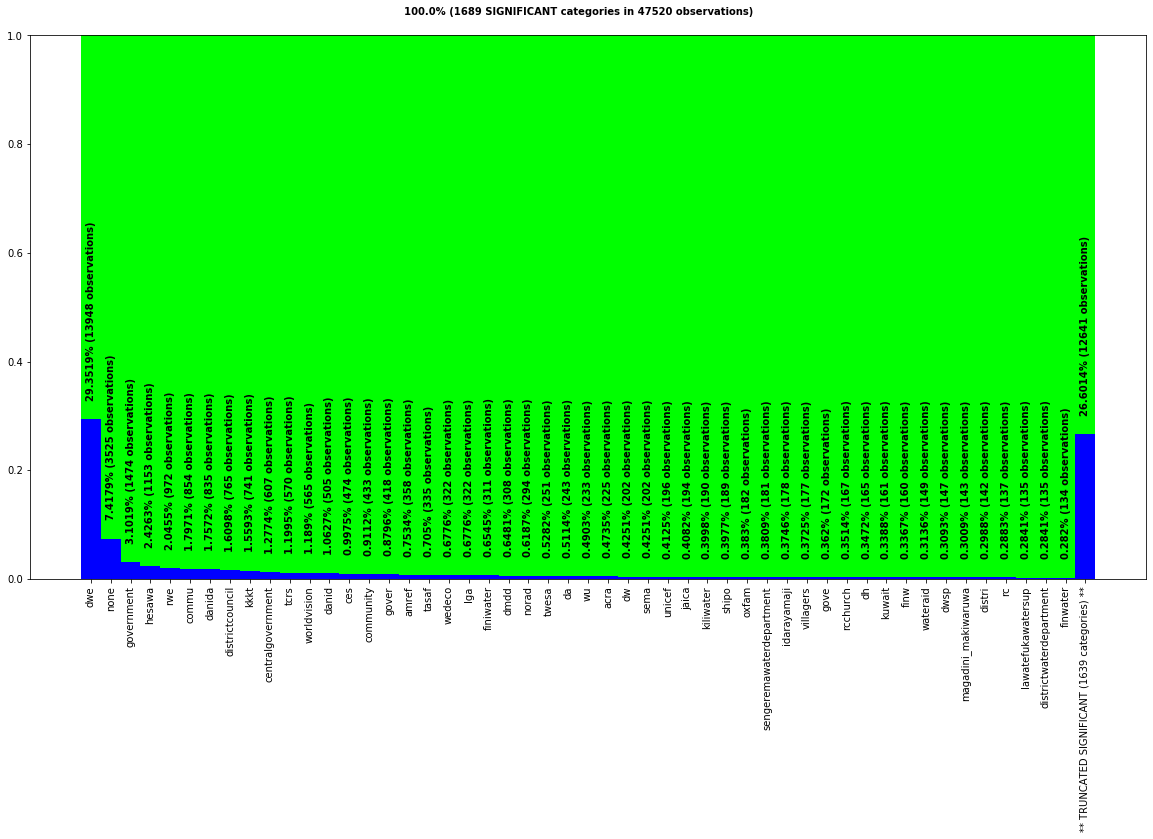

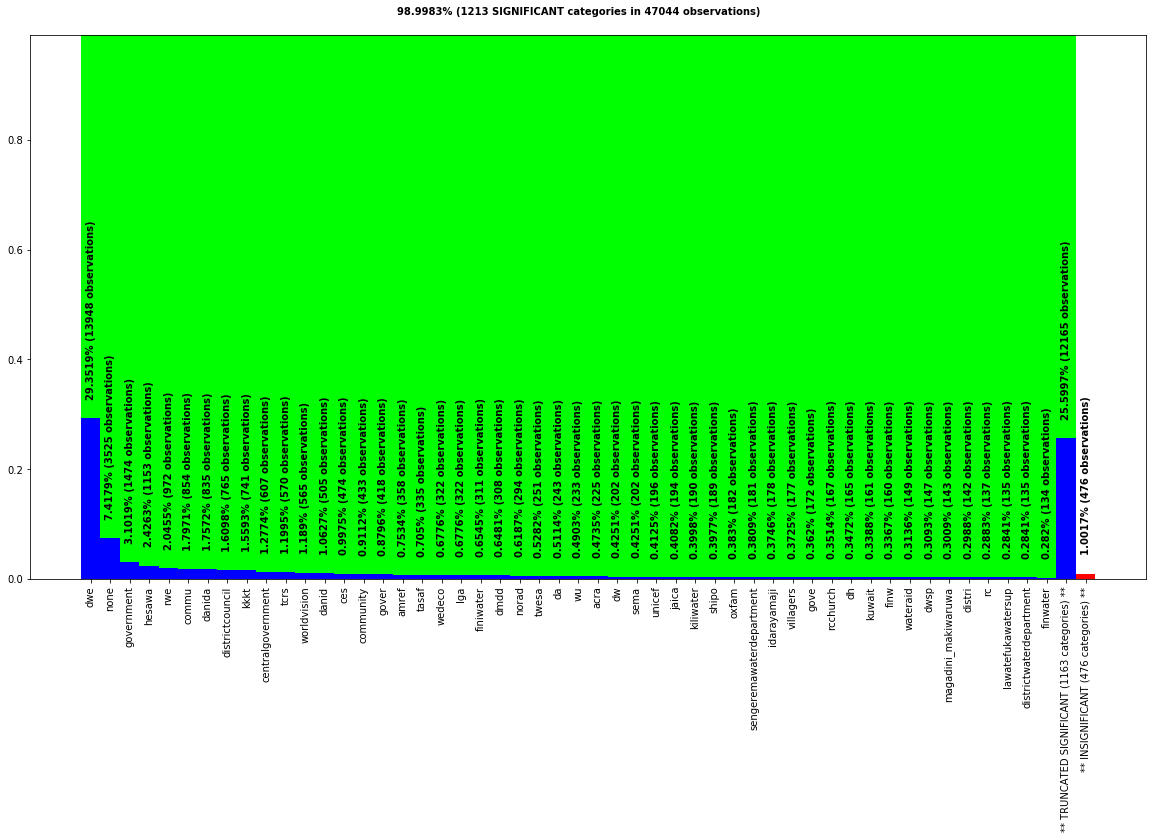

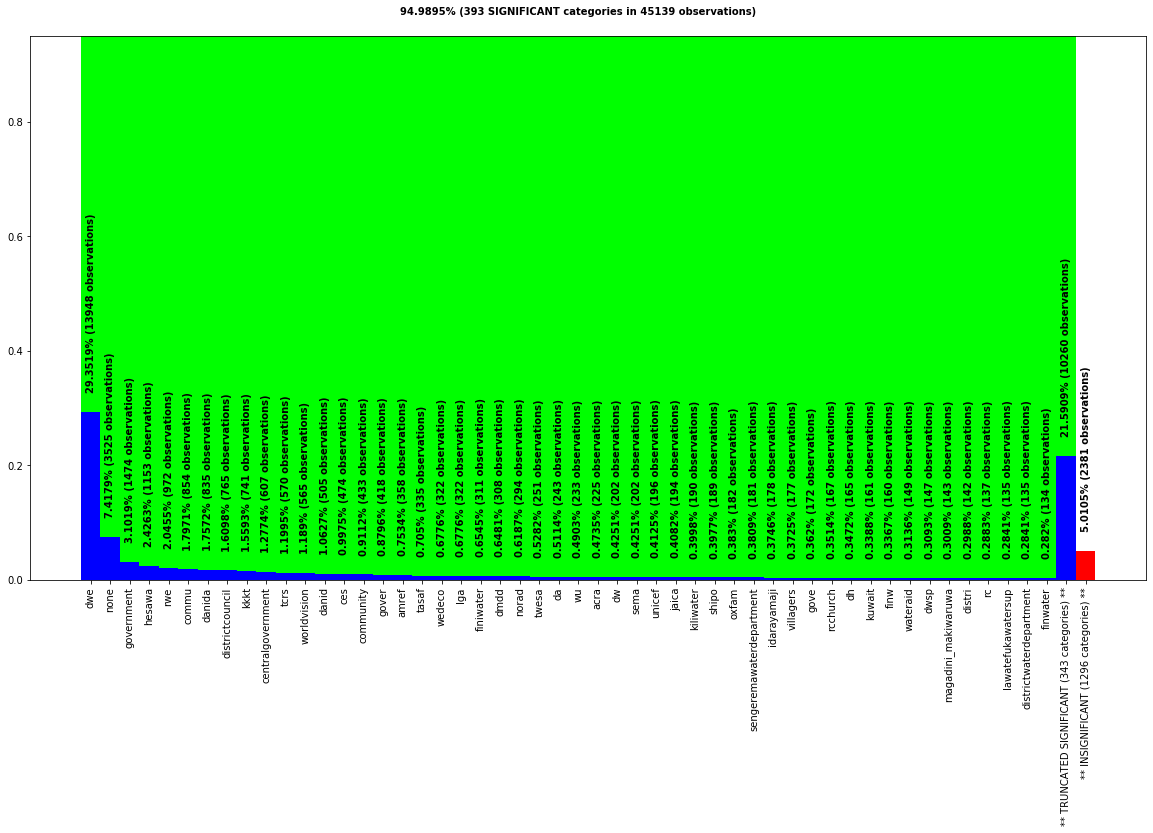

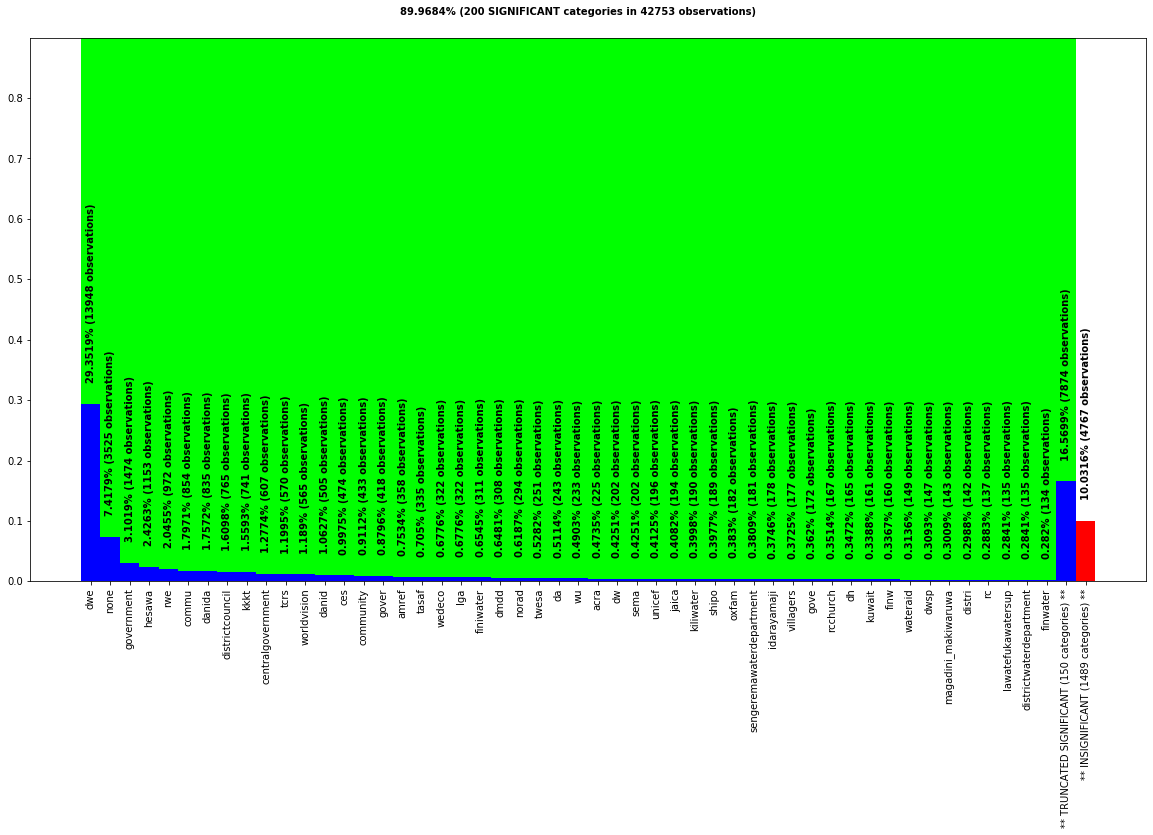

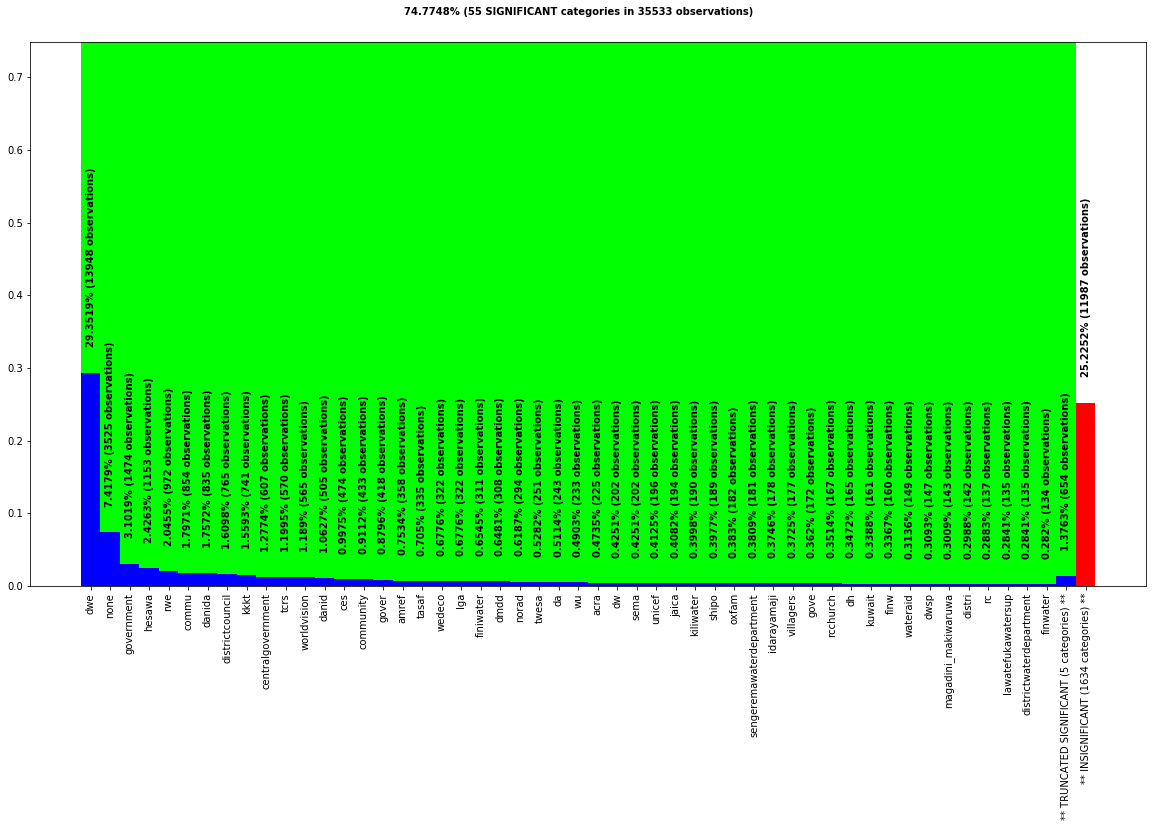

In [67]:
percentiles = [99, 95, 90, 75]
map_to_candidates = ['none', 'other', 'unknown']
truncate_sig_after_n = 50

installer_result_by_percentile = scjpnutils.analyze_categorical_reduction(
    X_train_cat, 
    'X_train_cat', 
    'installer', 
    percentiles=percentiles, 
    map_to_candidates=map_to_candidates, 
    truncate_sig_after_n=truncate_sig_after_n
)

By selecting categories from the top 90% (by count) of feature <b>installer</b>, we reduce the magnitude of the set of unique categories from 1689 to 200 (a 744.5% reduction in magnitude).  This will yield a significant reduction of One-Hot Encoded column explosion and, consequently, a significant performance gain when building classification models.

Now we just need to map the insignificant categories

In [68]:
sig = 90

display(HTML(f"There are {len(installer_result_by_percentile[sig]['insig'][0])} unique categories in {len(installer_result_by_percentile[sig]['insig'][1])} INSIGNIFICANT (bottom {100-sig}%) <b>installer</b> observations."))
display(HTML(f"Occurrence of candidate-map-to-categories in these INSIGNIFICANT categories is as follows: {installer_result_by_percentile[sig]['insig'][2]}."))

We will map these INSIGNIFICANT 1489 categories (4767 observations) to 'other'.

In [69]:
replace_insig_installer_rules = []
for insig_cat_val in installer_result_by_percentile[90]['insig'][0]:
    replace_insig_installer_rules.append({
        'missing_values': insig_cat_val,
        'strategy': 'constant',
        'fill_value': 'other'
    })
replace_insig_installer_rules = {'installer': replace_insig_installer_rules}
svt_insig_installers = SimpleValueTransformer(replace_insig_installer_rules)
X_train_cat = svt_insig_installers.fit_transform(X_train_cat)

# do the same for "throw-away" version of X_unlabeled and X_test since we will use union of unique categories between them for one-hot encoding
X_unlabeled_cat_throw_away = svt_insig_installers.fit_transform(X_unlabeled_cat_throw_away)
X_test_cat_throw_away = svt_insig_installers.fit_transform(X_test_cat_throw_away)

<p><br>
<h5>scheme_name</h5>

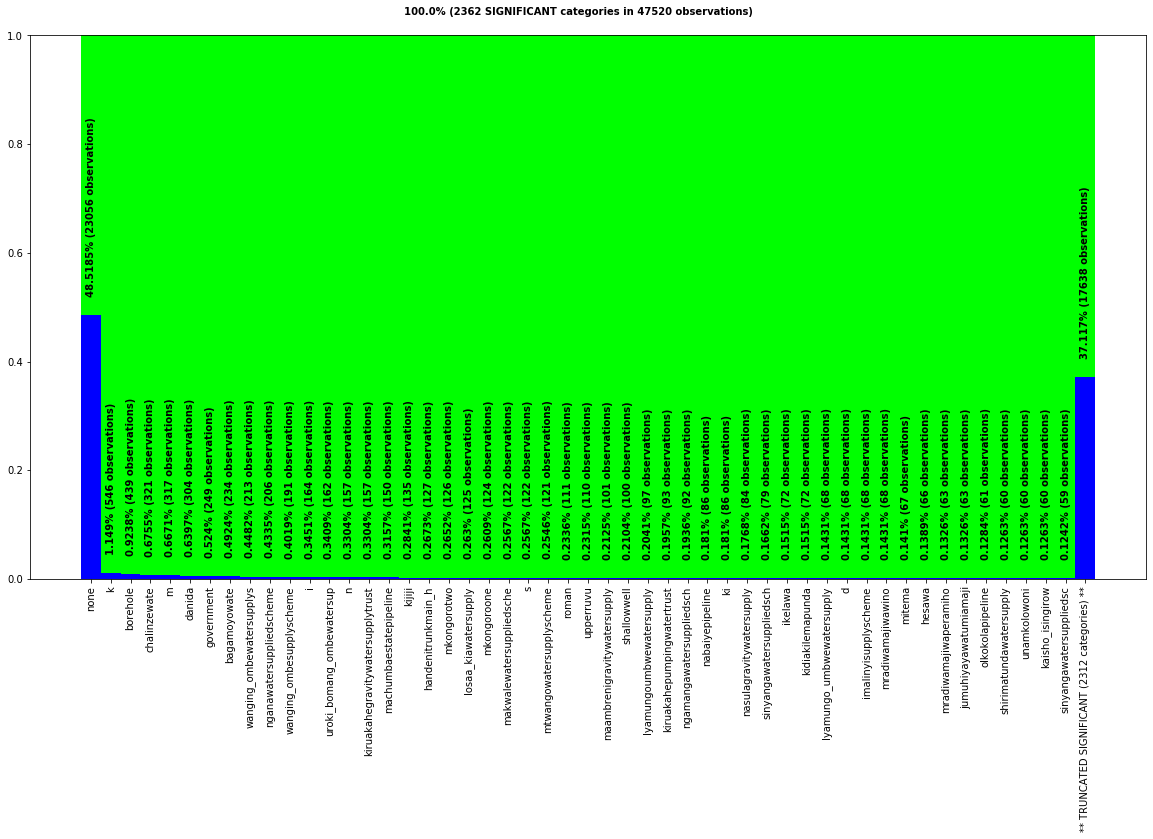

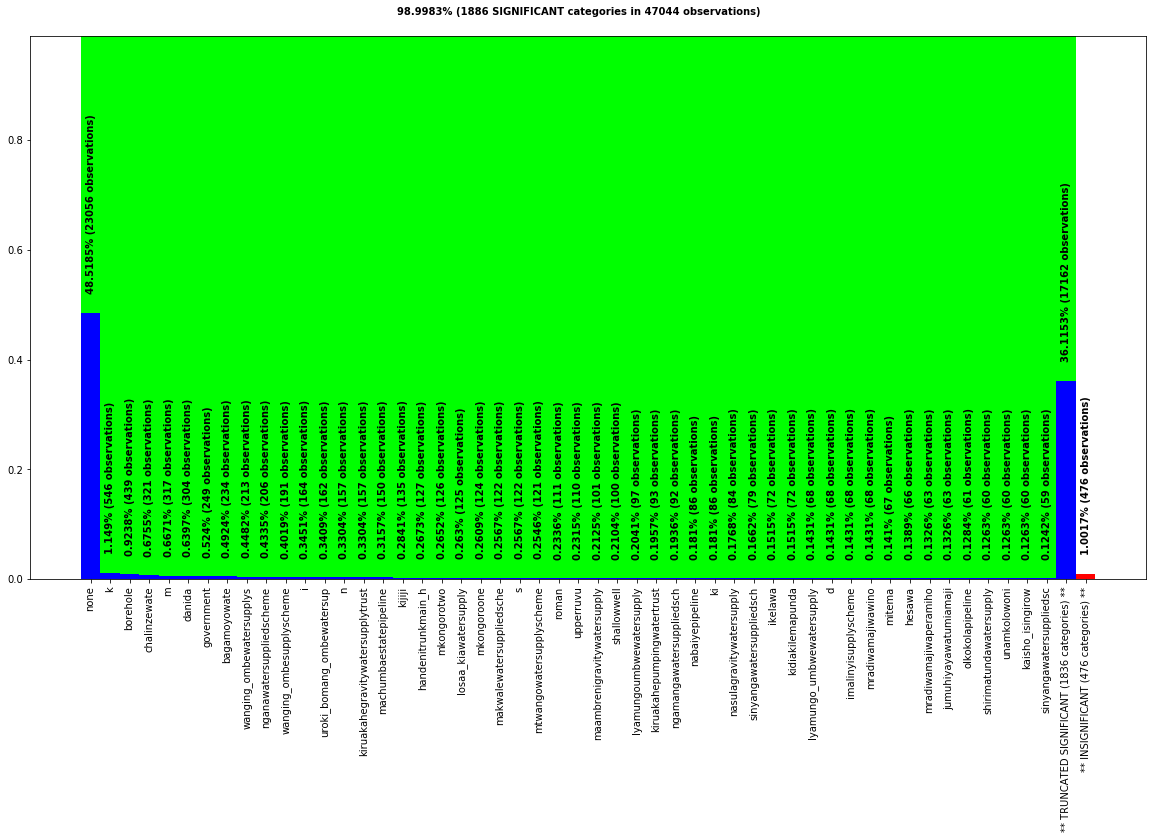

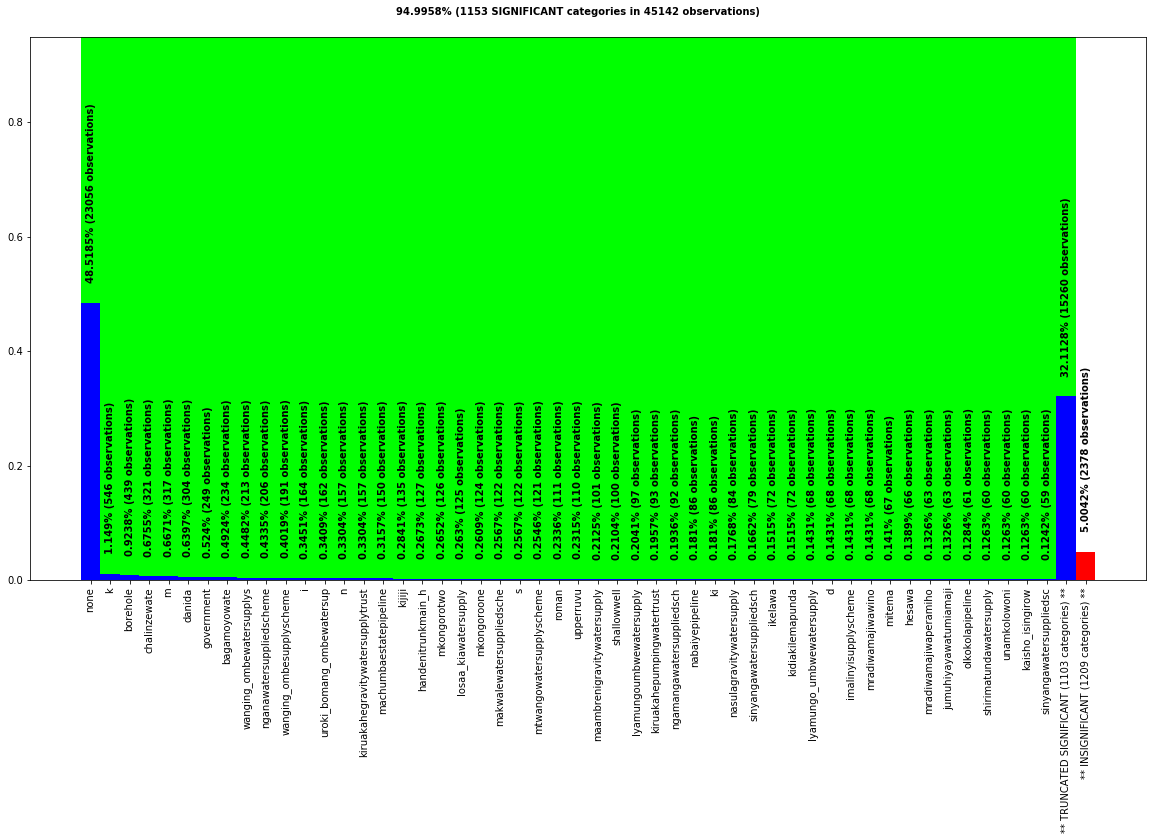

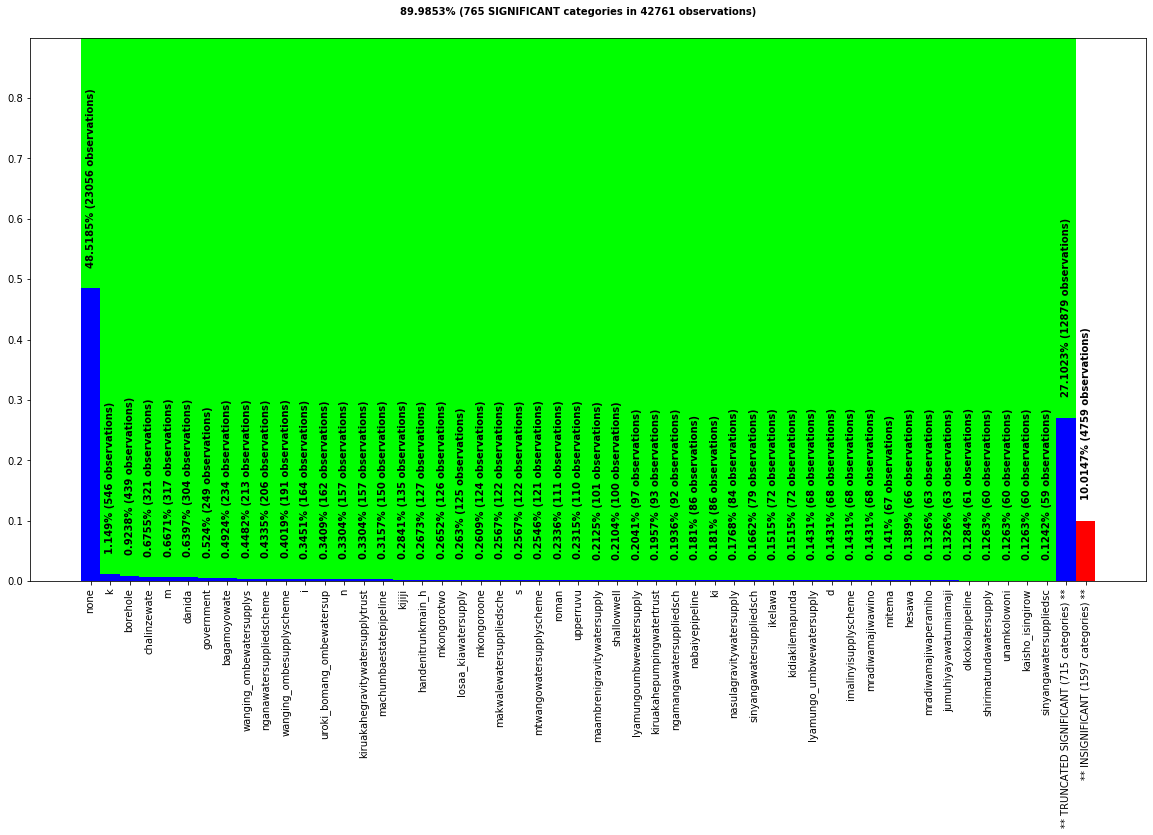

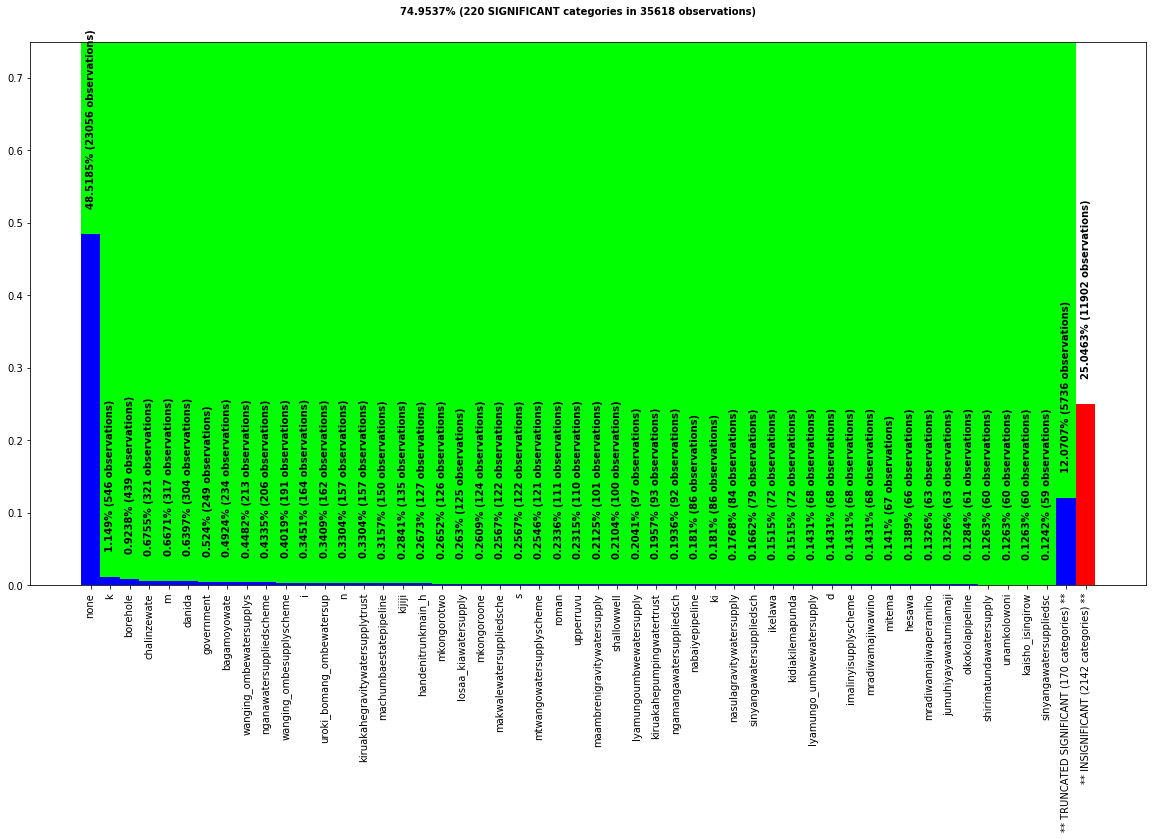

In [70]:
scheme_name_result_by_percentile = scjpnutils.analyze_categorical_reduction(
    X_train_cat, 
    'X_train_cat', 
    'scheme_name', 
    percentiles=percentiles, 
    truncate_sig_after_n=truncate_sig_after_n
)

Again, by selecting categories from the top 90% (by count) of feature <b>scheme_name</b>, we reduce the magnitude of the set of unique categories from 2362 to 765 (a 208.76% reduction in size).  This will yield a significant reduction of One-Hot Encoded column explosion and, consequently, a significant performance gain when building classification models.

In [71]:
sig = 90

display(HTML(f"There are {len(scheme_name_result_by_percentile[sig]['insig'][0])} unique categories in {len(scheme_name_result_by_percentile[sig]['insig'][1])} INSIGNIFICANT (bottom {100-sig}%) <b>scheme_name</b> observations."))
display(HTML(f"Occurrence of candidate-map-to-categories in these INSIGNIFICANT categories is as follows: {scheme_name_result_by_percentile[sig]['insig'][2]}."))

We will map these INSIGNIFICANT 1597 categories (4759 observations) to 'other'.

In [72]:
replace_insig_scheme_name_rules = []
for insig_cat_val in scheme_name_result_by_percentile[90]['insig'][0]:
    replace_insig_scheme_name_rules.append({
        'missing_values': insig_cat_val,
        'strategy': 'constant',
        'fill_value': 'other'
    })
replace_insig_scheme_name_rules = {'scheme_name': replace_insig_scheme_name_rules}
svt_insig_scheme_name = SimpleValueTransformer(replace_insig_scheme_name_rules)
X_train_cat = svt_insig_scheme_name.fit_transform(X_train_cat)

# do the same for "throw-away" version of X_unlabeled and X_test since we will use union of unique categories between them for one-hot encoding
X_unlabeled_cat_throw_away = svt_insig_scheme_name.fit_transform(X_unlabeled_cat_throw_away)
X_test_cat_throw_away = svt_insig_scheme_name.fit_transform(X_test_cat_throw_away)

In [73]:
scjpnutils.analyze_values(X_train_cat, 'X_train_cat', standard_options_kargs={'sort_unique_vals':True});

<p><br>
<h4>One-Hot Encoding</h4>

In [74]:
# first compute union of all CLEANED categories
ohe_categories = []
for cat_feat in cat_feats:
    categories_union = set()

    categories_for_feat__X_train = set(X_train_cat[cat_feat].unique())
    categories_union |= categories_for_feat__X_train

    categories_for_feat__X_test_cat_throw_away = set(X_test_cat_throw_away[cat_feat].unique())
    categories_union |= categories_for_feat__X_test_cat_throw_away

    categories_for_feat__X_unlabeled_cat_throw_away = set(X_unlabeled_cat_throw_away[cat_feat].unique())
    categories_union |= categories_for_feat__X_unlabeled_cat_throw_away

    ohe_categories.append(list(categories_union))

ohe_cat_predictors = OneHotEncodingTransformer(cat_feats_to_encode=cat_feats, categories_by_feat_idx=ohe_categories)
X_train_cat_dummies = ohe_cat_predictors.fit_transform(X_train_cat)

X_train_cat_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Columns: 1702 entries, installer_accra to waterpoint_type_dam
dtypes: float64(1702)
memory usage: 617.4 MB


<p><br>
<h3>Final TRAINING Data</h3>
<h4>Prepare the Transformers Pipeline for Later Use (on TESTING data)</h4>

In [75]:
data_cleaner = Pipeline(
    steps=[
        ('drop_non_contrib', dct_non_contrib_predictors),
        ('null_imputer', nvt_null_predictors),
        ('drop_dup', dct_dup_predictors),
    ]
)

# Continuous
continuous_transformer = Pipeline(
    steps=[
        ('data_cleaner', data_cleaner),
        ('sel_cont', ft_sel_cont),
        ('drop_cont_predictors_with_bad_outliers', dct_cont_predictors_with_bad_outliers),
        ('svt_cont_outlier_predictors', svt_cont_outlier_predictors),
        ('scaler', scaler)
    ]
)

# Categorical
categorical_transformer = Pipeline(
    steps=[
        ('data_cleaner', data_cleaner),
        ('dct_cat_predictors_from_cont_predictors', dct_cat_predictors_from_cont_predictors),
        ('lt_lcase_cat_predictors', lt_lcase_cat_predictors),
        ('lt_strip_ws_cat_predictors', lt_strip_ws_cat_predictors),
        ('lt_replace_non_alphanumeric_cat_predictors', lt_replace_non_alphanumeric_cat_predictors),
        ('svt_weird_installers', svt_weird_installers),
        ('svt_insig_installers', svt_insig_installers),
        ('svt_insig_scheme_name', svt_insig_scheme_name), 
        ('ohe', ohe_cat_predictors)
    ] 
)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cont', continuous_transformer, cont_feats) 
#         ('cat', categorical_transformer, cont_feats + cont_feats_to_drop) # note that we pass in list of cont_feats since cat_feats are assumed to be the complement
#     ]
# )

<p><br>
<h4>Test the Transformers Pipeline</h4>

In [76]:
#data_train = preprocessor.fit_transform()

# for now
data_train = pd.concat([X_train_cat_dummies, scaled_X_train_cont], axis=1, join='inner')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 3607 to 56422
Columns: 1707 entries, installer_accra to construction_year
dtypes: float64(1707)
memory usage: 619.2 MB


<p><br><br>
<h2>Clean TEST Predictors</h2>

<h3>Categorical</h3>

In [77]:
# test
# X_test_clean = categorical_transformer.fit_transform(X_test)
#scjpnutils.analyze_values(X_test_clean, 'X_test_clean')

X_test_cat_dummies = categorical_transformer.fit_transform(X_test).set_index(X_test.index)

X_test_cat_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11880 entries, 2980 to 41264
Columns: 1702 entries, installer_accra to waterpoint_type_dam
dtypes: float64(1702)
memory usage: 154.4 MB


<p><br>
<h3>Continuous</h3>

In [78]:
# test
scaled_X_test_cont = pd.DataFrame(continuous_transformer.transform(X_test), columns=X_train_cont.columns, index=X_test.index)

scaled_X_test_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11880 entries, 2980 to 41264
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gps_height         11880 non-null  float64
 1   longitude          11880 non-null  float64
 2   latitude           11880 non-null  float64
 3   population         11880 non-null  float64
 4   construction_year  11880 non-null  float64
dtypes: float64(5)
memory usage: 556.9 KB


<p><br>
<h3>Final TESTING Data</h3>

In [79]:
data_test = pd.concat([X_test_cat_dummies, scaled_X_test_cont], axis=1, join='inner')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11880 entries, 2980 to 41264
Columns: 1707 entries, installer_accra to construction_year
dtypes: float64(1707)
memory usage: 154.8 MB


In [80]:
# data_test = preprocessor.fit_transform(X_test)

<br><br>
<h2>Build Classification Models</h2>

In [81]:
SEED = 42

<h3>Random Forest</h3>

In [83]:
# # Original
# clf = RandomForestClassifier(
#     criterion = 'entropy',
#     n_estimators=100, 
#     max_depth=None,
#     random_state=SEED, 
#     n_jobs=-1,
#     verbose=1
# )
# clf.fit(data_train, y_train)


# GridSearchCV hyperparameters TUNING
param_grid = {
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 50, 100, None],
    'n_estimators': [10, 30, 100, 500, 1000],
    'n_jobs': [-1],
    'random_state': [SEED],
    'verbose': [1]
}

K = 5

clf = RandomForestClassifier()

# print(clf.get_params().keys())

grid_clf = GridSearchCV(
    clf, 
    param_grid, 
    cv=K, 
    n_jobs=-1, 
    verbose=20
)
grid_clf.fit(data_train, y_train)

best_parameters = grid_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Grid Search found the following optimal parameters: 
# bootstrap: True
# criterion: 'gini'
# max_depth: 50
# max_features: 'auto'
# n_estimators: 1000

# # according to the prior GridSearch...
# best_parameters = {}
# best_parameters['criterion'] = 'gini'
# best_parameters['bootstrap'] = True
# best_parameters['max_depth'] = 50
# best_parameters['max_features'] = 'auto'
# best_parameters['n_estimators'] = 1000

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 

In [84]:
# now fit the classifier to training data/labels using the best params
clf.set_params(**best_parameters)

# clf = RandomForestClassifier(
#     criterion=best_parameters['criterion'],
#     bootstrap=best_parameters['bootstrap'],
#     max_depth=best_parameters['max_depth'],
#     max_features=best_parameters['max_features'],
#     n_estimators=best_parameters['n_estimators'],

#     random_state=SEED, 
#     n_jobs=-1,
#     verbose=1
# )

clf.fit(data_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

<h4>Predictions</h4>

<h5>TRAINING Data</h5>

In [85]:
pred_train = clf.predict(data_train)
print("\n", clf.score(data_train, y_train), "\n")
print(classification_report(y_train, pred_train, target_names=classes))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    4.9s finished

 0.9936868686868687 

                         precision    recall  f1-score   support

             functional       0.99      1.00      0.99     25802
         non functional       0.98      0.96      0.97      3466
functional needs repair       1.00      0.99      1.00     18252

               accuracy                          

<h5>TESTING Data</h5>

In [86]:
pred_test = clf.predict(data_test)
print("\n", clf.score(data_test, y_test), "\n")
print(classification_report(y_test, pred_test, target_names=classes))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.3s finished

 0.8028619528619528 

                         precision    recall  f1-score   support

             functional       0.81      0.88      0.84      6457
         non functional       0.53      0.35      0.42       851
functional needs repair       0.83      0.78      0.81      4572

               accuracy                          

<p><br>
<h3>XGBoost</h3>

In [87]:
# from sklearn.preprocessing import LabelEncoder

# param_grid = {
#     'objective': ['multi:softmax'],
#     'num_classes': [len(classes)],
#     # 'learning_rate': [0.1, 0.3, 0.6, 1.0],
#     # 'max_depth': [3, 6, 9],
#     # 'min_child_weight': [1, 3, 5],
#     # 'subsample': [0.1, 0.5, 1.0],
#     # 'n_estimators': [10, 30, 100],
#     'gamma': [0, 10, 20]
# }

In [88]:
# # ORIGINAL
# clf = XGBClassifier(
#     objective='multi:softmax', 
#     num_classes=len(classes), 
#     n_estimators=100, 
#     # max_depth=None, 
#     silent=0,
#     random_state=SEED,
#     n_jobs=-1,
#     verbose=1
# )
# clf.fit(data_train, y_train)



# # GridSearchCV hyperparameters TUNING
# K = 5

# clf = XGBClassifier(random_state=SEED)
# grid_clf = GridSearchCV(
#     clf, 
#     param_grid, 
#     cv=K, 
#     n_jobs=-1, 
#     verbose=20
# )
# grid_clf.fit(data_train, y_train)

# best_parameters = grid_clf.best_params_
# print("Grid Search found the following optimal parameters: ")
# for param_name in sorted(best_parameters.keys()):
#     print("%s: %r" % (param_name, best_parameters[param_name]))

# # now fit the classifier to training data/labels using the best params
# # clf = XGBClassifier(
# #     objective=best_parameters['objective'],
# #     num_classes=best_parameters['num_classes'],
# #     learning_rate=best_parameters['learning_rate'],
# #     max_depth=best_parameters['max_depth'],
# #     min_child_weight=best_parameters['min_child_weight'],
# #     subsample=best_parameters['min_child_weight'],
# #     n_estimators=best_parameters['n_estimators'],
# #     random_state=SEED,
# #     n_jobs=-1,
# #     verbose=1
# # )
# # clf.set_params(**param_grid)
# clf.set_params(**best_parameters)
# clf.fit(data_train, y_train)

In [89]:
# pred_train = clf.predict(data_train)
# print("\n", clf.score(data_train, y_train), "\n")
# training_accuracy = accuracy_score(y_train, pred_train)
# print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
# print(classification_report(y_train, pred_train, target_names=classes))

In [90]:
# pred_test = clf.predict(data_test)
# print("\n", clf.score(data_test, y_test), "\n")
# testing_accuracy = accuracy_score(y_test, pred_test)
# print("Testing Accuracy: {:.4}%".format(testing_accuracy * 100))
# print(classification_report(y_test, pred_test, target_names=classes))